#### Importing packages

In [1]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#

import pyseobnr
from pyseobnr.generate_waveform import GenerateWaveform
from matplotlib import rcParams

rcParams.update({'figure.autolayout': True, "text.usetex": True})
#mpl.rcParams['figure.dpi'] = 200

import matplotlib as mpl

 
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt


/home/pratul/anaconda3/envs/pyseob/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


#### Moore et.al. definition of eccentricity

In [2]:
# Eq. (4.17a, 4.17b), Pg. 18, Moore et al (2016)

def epsilon(xi, eta):
    return(( 1 + ( ( -2833/2016 + 197/72 * eta ) * ( xi )**( 2/3 ) + 
                  ( -377/144 * np.pi * xi + ( ( 77006005/24385536 + ( -1143767/145152 * eta + 
 	 43807/10368 * ( eta )**( 2 ) ) ) * ( xi )**( 4/3 ) + ( np.pi * ( 9901567/1451520 + 
 	 -202589/362880 * eta ) * ( xi )**( 5/3 ) + ( xi )**( 2 ) * ( -33320661414619/386266890240 + 
 	 ( 3317/252 * EulerGamma + ( 180721/41472 * ( np.pi )**( 2 ) + ( ( 161339510737/8778792960 + 
 	 3977/2304 * ( np.pi )**( 2 ) ) * eta + ( -359037739/20901888 * ( eta )**( 2 ) + 
      ( 10647791/2239488 * ( eta )**( 3 ) + ( -87419/3780 * np.log( 2 ) + 
 	 ( 26001/1120 * np.log( 3 ) + 3317/504 * np.log( 16 * ( xi )**( 2/3 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ))

#### Analytical Fits expressions

In [3]:
# "Hinder+ modified all 20 simulations SEOBNRv4 model, full frequency range --Feb 16
g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tshift_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
A=[] 
for x in lines: 
    A.append(float(x.split()[1])) 
g.close()

def tshift_Hinsp(q,e,l): 
    return A[0] + A[1]*q + A[2]*q**2 + A[3]*e + A[4]*e**2 + A[5]*e*q + A[6]*(e**2)*q + A[7]*(e)*math.cos(l + A[8]) + A[9]*(e**1)*(q**1)*math.cos(e*l + A[10]) + A[11]*(e**2)*math.cos(l + A[12])

g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tamp_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
B=[] 
for x in lines: 
    B.append(float(x.split()[1])) 
g.close()

def tamp_Hinsp(eta,e,l): 
    return B[0] + B[1]*eta + B[2]*eta**2 + B[3]*e + B[4]*e**2 + B[5]*e*eta + B[6]*(e**2)*eta + B[7]*e*math.cos(l + B[8]) + B[9]*(e**1)*(eta**1)*math.cos(l + B[10]) + B[11]*(e**2)*math.cos(e*l + B[12])

g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tfreq_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
C=[] 
for x in lines: 
    C.append(float(x.split()[1])) 
g.close()

def tfreq_Hinsp(eta,e,l): 
    return C[0] + C[1]*eta + C[2]*eta**2 + C[3]*e + C[4]*e**2 + C[5]*e*eta + C[6]*(e**2)*eta + C[7]*e*eta*math.cos(l + C[8]) + C[9]*(e)*math.cos(l + C[10]) + C[11]*(e**2)*math.cos(e*l + C[12])

#### Spherical Harmonics

In [4]:
def sph_harmonics(inc,ell):
    L=ell
    #inc = 10
    theta = inc
    for l in range(L,L+1):

        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
            if m==ell:
                #globals()['sph' + str(l) + str(m)] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphlm = Ylm
            elif m==-ell:
                #globals()['sph' + str(l) + '_' + str(abs(m))] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphl_m = Ylm
            else:
                continue
    return sphlm, sphl_m

#### Frequency Conversion Factors

In [5]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion


In [6]:
fconv(0.039,25)

19.909369369412758

#### Function that can call any $(l, m)$ mode model for mismatch calculation

In [7]:
def eccmodel(Mass,q0,e0,l0,fmin,inclination=0,d=1,delta_t=1./4096,modes=[[2,2]]):
    
    #delta_t=0.00015208911520102518
    #delta_t = 1/2**20
    ell = []
    numrows = len(modes)
    numcols = len(modes[0])
    for i in range(0,numrows):
        l = modes[i][0]
        m = modes[i][1]
        ell.append(l)
    angle = inclination
    waveform = {}
    count = 0
    el = 2
    if el in ell:
        mode_data = {}
        mode_data['hp'], mode_data['hc'], mode_data['t'] = model_22(Mass,q0,e0,l0,fmin,angle,d,delta_t)
        waveform['l2_m2'] = mode_data
        count = count + 1

    el = 3
    if el in ell:
        mode_data = {}
        mode_data['hp'], mode_data['hc'], mode_data['t'] = MODEL33(Mass,q0,e0,l0,fmin,angle,d,delta_t)
        waveform['l3_m3'] = mode_data
        count = count + 1
        
    el = 4
    if el in ell:
        mode_data = {}
        mode_data['hp'], mode_data['hc'], mode_data['t'] = MODEL44(Mass,q0,e0,l0,fmin,angle,d,delta_t)
        waveform['l4_m4'] = mode_data
        count = count + 1
        
    el = 5
    if el in ell:
        mode_data = {}
        mode_data['hp'], mode_data['hc'], mode_data['t'] = MODEL55(Mass,q0,e0,l0,fmin,angle,d,delta_t)
        waveform['l5_m5'] = mode_data
        count = count + 1
        
    len_max_mode = '0'
    len_max = 0
    for mode in waveform.keys():
        if len(waveform[mode]['t'])>len_max:
            len_max_mode = mode
            len_max = len(waveform[mode]['t'])
            
    for mode in waveform.keys():
        if mode != len_max_mode:
            waveform[mode]['hp'].resize(len_max)
            waveform[mode]['hc'].resize(len_max)
            
    hp=0
    hc=0
    time=waveform[len_max_mode]['t']
    for mode in waveform.keys():
        hp = hp + waveform[mode]['hp']
        hc = hc + waveform[mode]['hc']
        
    hplus = TimeSeries(hp,delta_t,epoch=time[0])
    hcross = TimeSeries(hc,delta_t,epoch=time[0])
    
    return hplus, hcross

#### PN, NR, Hybrid, Model Comparisons

In [10]:
#hfile = ['/home/pratul/Downloads/Project/New hybrids/mixed_hybrids/1364_EccTD_Ebersold_HM_hyb.h5'] 
hfile = ['/home/pratul/Downloads/Project/New hybrids/Final_hybrids/1364_EccTD_Ebersold_hybrid.h5']    


def model_22(m,q0,e0,l0,fmin,angle,d,delta_t):
    
    
    for i in range(0,len(hfile)):
        hyb_name = hfile[i][0:4]
        f = h5py.File(hfile[i],'r')
        data = f['l2_m2']
        tVec = real(data[0:,0])
        h22pVec = real(data[0:,1])
        h22cVec = real(data[0:,2])
        mode2polfac=4*(5/(64*np.pi))**(1/2)
        hpVec=h22pVec
        hcVec=h22cVec

        tVec = tVec - tVec[np.argmax(abs(hpVec + 1j*hcVec))]
        M=m
        q=q0
        M1 = q*M/(1+q)
        M2 = M/(1+q)
        eta = q/(1+q)**2

        M_SI=M*MSUN_SI
        D_SI=(10**(6))*PC_SI
        tVec=tVec*M*MTSUN_SI
        hpVec=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
        hcVec=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    
    
        tVec = tVec - tVec[np.argmax(abs(hpVec + 1j*hcVec))]

        delta_t = delta_t_NR = np.abs(np.mean((np.diff(tVec))))

        fref = 0.075**(3/2) /MTSUN_SI/ PI/M
        xmin = xconv(fmin,30)
        print('xlow=',xmin)
        fmin = fconv(xmin,M)


        hp, hc = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, eccentricity=e0)
        #sp, sc = get_td_waveform(approximant='SEOBNRv4', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin)
        
        wfm_gen = GenerateWaveform({"mass1": M1,"mass2": M2,"spin1x": 0, "spin1y": 0, "spin1z": 0, "spin2x": 0, "spin2y": 0, 
        "spin2z": 0, "deltaT": delta_t, "f22_start": fmin,"distance": 1,"inclination": 0,"approximant": "SEOBNRv5HM"})

        times_eob, hlm_eob = wfm_gen.generate_td_modes()
        times_eob = times_eob - times_eob[np.argmax(abs(hlm_eob[(2,2)]))]
        #plt.plot(times,hlm_eob[(2,2)])
        sp = np.real(hlm_eob[(2,2)]) * mode2polfac
        sc = np.imag(hlm_eob[(2,2)]) * mode2polfac

        #plt.plot(sp.sample_times,sp)
        
        #NR
        simulation = '/home/pratul/Downloads/Project/NR_data/1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5'
        sims = simulation.split('_')[0]
        lp = 2 #modes
        mp = 2
        tref = 640  # Varies depending on simulations
        mode = 'l'+str(lp)+'_m'+str(mp)
        with h5py.File(simulation, 'r') as hdf:
            temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
            test=np.array(temp)

        x1=test[:,0]
        y1=test[:,1]    
        z1=test[:,2]


        plotband=np.where(x1>=tref)
        x1=x1[plotband]
        x1=x1-x1[np.argmax(abs(y1))]
        y1=y1[plotband]    
        z1=z1[plotband]
        NRAmp = abs(y1-1j*z1)

        tot=y1-1j*z1
        amp=abs(tot)
        ph=np.angle(tot)
        phase_NR=np.unwrap(ph)
        w=np.absolute(diff(phase_NR)/diff(x1))
        phi0=phase_NR[0]

        
        
        
        "time shift"
        "Hinder+ inspired"
        
        tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI                 
        
        
        
        tmin = max(tVec[0],hp.sample_times[0]-tshift,times_eob[0]) #sp.sample_times[0])

        #alternate
        plotband = np.where(tVec>=tmin)[0][0]
        hpVec = hpVec[plotband:]
        hcVec = hcVec[plotband:]
        tVec = tVec[plotband:]


        h22Hyb = hpVec + 1j*hcVec
        tVec = tVec - tVec[np.argmax(abs(h22Hyb))]
        phaseHyb = -np.unwrap(np.angle(h22Hyb)*2)/2
        omegaHyb = (M*MTSUN_SI/delta_t)*(np.gradient(phaseHyb))


        #circular IMR
        sp_intrp = interp1d(times_eob, sp, kind='cubic',fill_value='extrapolate')
        sc_intrp = interp1d(times_eob, sc, kind='cubic',fill_value='extrapolate')
        tImr_intrp=np.arange(tmin, times_eob[-1], delta_t)  #change for v5HM
        sp_intrp = sp_intrp(tImr_intrp)
        sc_intrp = sc_intrp(tImr_intrp)
        tImr = tImr_intrp
        hpImr = sp_intrp
        hcImr = sc_intrp
        h22Imr = hpImr + 1j*hcImr


        

        # interpolation EccentricTD
        
        hp_intrp = interp1d(hp.sample_times-tshift, hp, kind='cubic',fill_value='extrapolate')
        hc_intrp = interp1d(hc.sample_times-tshift, hc, kind='cubic',fill_value='extrapolate')
        # new (unifrom) sampling rate (for interpolation and further processing)
        tEcc_intrp=np.arange(tmin, hp.sample_times[-1]-tshift, delta_t)
        hp_intrp = hp_intrp(tEcc_intrp)
        hc_intrp = hc_intrp(tEcc_intrp)
        tEcc = tEcc_intrp
        hpEcc = hp_intrp
        hcEcc = hc_intrp
        h22Ecc = hpEcc + 1j*hcEcc

        phaseEcc = np.unwrap(np.angle(h22Ecc)*2)/2
        phaseImr = abs(np.unwrap(np.angle(h22Imr)*2)/2)

        #######
        dphase = phaseEcc[0] - phaseImr[0]
        hp_new = real(h22Ecc * exp(-1j * dphase))
        hc_new = imag(h22Ecc * exp(-1j * dphase))
        
        
 
        phase_new = np.unwrap(np.angle(hp_new+1j*hc_new)*2)/2

        phaseEcc = phase_new 
        h22Ecc_new = hp_new+1j*hc_new

        "Hinder+ inspired"
        arg = np.argmin(abs(tEcc - tamp_Hinsp(eta,e0,l0)*M*MTSUN_SI)) 
        Idxjoin = arg 

        "Hinder+ inspired"
        t_amp = tEcc[Idxjoin] - 500*M*MTSUN_SI
        idxstr = np.argmin(abs(tEcc-t_amp))

        "amplitude model"
        amp = []
        count = 0
        length = Idxjoin - idxstr 

        for i in range(idxstr,Idxjoin):
            amp.append(((length-count)*abs(h22Ecc_new[i])+count*abs(h22Imr[i]))/length)
            count = count+1

        t_model = np.concatenate((tEcc[0:Idxjoin],tImr[Idxjoin:len(tImr)]))
        h22amp = np.concatenate((abs(h22Ecc_new[0:idxstr]),amp))
        h22amp_model = np.concatenate((h22amp,abs(h22Imr[Idxjoin:len(h22Imr)])))

        omegaEcc = (M*MTSUN_SI/delta_t)*(np.gradient(phaseEcc))
        omegaImr = (M*MTSUN_SI/delta_t)*(np.gradient(phaseImr))
        

        "Hider+ inspired"
        tjoin0 = tfreq_Hinsp(eta,e0,l0)                                
        
        
        tjoin = tjoin0 * M * MTSUN_SI
        fjoin = np.argmin(abs(tEcc-tjoin)) #+ 500


        "frequency model"
        tstop = min(tEcc[-1],-30*M*MTSUN_SI)
        lst = np.argmin(abs(tEcc-tstop))


        indx = lst - fjoin
        a0 = []
        n = indx - 1 
        k = 0
        for i in range(fjoin,fjoin+indx):   #fjoin - 500
            a0.append(((n-k)*omegaEcc[i]+k*omegaImr[i])/n)
            k = k+1

        f1 = np.concatenate((omegaEcc[0:fjoin],a0))
        frequency_model = np.concatenate((f1,omegaImr[fjoin+indx:len(omegaImr)]))
        phase_f_model = np.cumsum(frequency_model)/(M*MTSUN_SI/delta_t) + PI/1.4#PI/2.1#PI/0.1#
        phase_f_model = phase_f_model - phase_f_model[0]+phaseEcc[0]

        hp_f_model = h22amp_model * np.cos(phase_f_model)
        hc_f_model = h22amp_model * np.sin(phase_f_model)
    
        ht = (mode2polfac/4)*(((1+math.cos(angle))**2 * (hp_f_model - 1j*hc_f_model)) + ((1-math.cos(angle))**2 * (hp_f_model + 1j*hc_f_model)))
        hplus = np.real(ht)
        hcross = np.imag(ht)
    
        hp_model_TS = TimeSeries(hplus,delta_t)
        hc_model_TS = TimeSeries(hcross,delta_t)
    
        #return hp_model_TS, hc_model_TS, t_model
    
        
        
        plt.figure(figsize=(10,4.8))
        plt.rc('xtick', labelsize=16, direction ='in') 
        plt.rc('ytick', labelsize=16, direction ='in') 
        mpl.rcParams['xtick.major.size'] = 12
        mpl.rcParams['xtick.major.width'] = 1
        mpl.rcParams['xtick.minor.size'] = 8
        mpl.rcParams['xtick.minor.width'] = 1
        mpl.rcParams['ytick.major.size'] = 12
        mpl.rcParams['ytick.major.width'] = 1
        mpl.rcParams['ytick.minor.size'] = 8
        mpl.rcParams['ytick.minor.width'] = 1
        plt.locator_params(axis='y',nbins=6)
        plt.tick_params(axis='y',direction='in',right=True)
        plt.tick_params(axis='x',direction='in',top=True)

        plt.plot(tVec/(M*MTSUN_SI), omegaHyb,color='navajowhite',linewidth=8,alpha = 1,label='Hybrid',zorder=1)
        plt.plot(t_model/(M*MTSUN_SI), frequency_model, color='saddlebrown',alpha=1,linestyle='--',linewidth=2,label='Model',zorder=3)
        plt.plot(tEcc/(M*MTSUN_SI)-10,omegaEcc,linestyle='-',linewidth=2,color='springgreen',alpha=0.8,label='EccentricTD',zorder=2)
        plt.plot(tImr/(M*MTSUN_SI),omegaImr,linestyle='-',linewidth=2,color='dodgerblue',alpha=0.8,label='SEOBNRv4',zorder=2)
        #plt.plot((x1-x1[np.argmax(NRAmp)])[:len(w)], w,color='navajowhite',linewidth=4,alpha = 1,label='NR',zorder=1)
        
        
        plt.xlim(xmin=-5500)
        plt.xlim(xmax=100)
        plt.ylim(ymin=1.5e-2)
        plt.ylim(ymax=3e-1)
        plt.axvline(x=tjoin/(M*MTSUN_SI),color='grey',linestyle=':',zorder=5,alpha=0.6)
        #plt.axvline(x=-2000,color='grey',linestyle=':',zorder=5,alpha=0.6)
        #plt.axvline(x=-1000,color='grey',linestyle=':',zorder=5,alpha=0.6)
        plt.axvline(x=tstop/(M*MTSUN_SI),color='grey',linestyle=':',zorder=5,alpha=0.2)
        #plt.axvspan(-2000,-1000,color='lightgrey',alpha=0.3)
        plt.axvspan(tjoin/(M*MTSUN_SI),tstop/(M*MTSUN_SI),color='lightgrey',alpha=0.3)
        plt.ylabel(r'$M \omega_{22}$',fontsize=22,labelpad=5)
        plt.xlabel(r'$t/M$',fontsize=22)
        #leg = plt.legend(ncol=2,loc=2,bbox_to_anchor=(0.02,0.96),prop={'size': 16.5})
        #leg._legend_box.align = "center"
        plt.text(-1210,9e-2,r'$t_{\rm{match}}^\omega$',fontsize=18)
        plt.yscale('log')
        plt.tick_params(axis='x', which='minor', bottom=False, top=False)
        plt.tight_layout()
        # plt.savefig("/home/pratul/Downloads/Project/Plots_draft/1355_Model_Freq.pdf",dpi=300)
        

    
    
        plt.figure(figsize=(10,4.8))
        plt.rc('xtick', labelsize=16, direction ='in') 
        plt.rc('ytick', labelsize=16, direction ='in') 
        mpl.rcParams['xtick.major.size'] = 12
        mpl.rcParams['xtick.major.width'] = 1
        mpl.rcParams['xtick.minor.size'] = 8
        mpl.rcParams['xtick.minor.width'] = 1
        mpl.rcParams['ytick.major.size'] = 12
        mpl.rcParams['ytick.major.width'] = 1
        mpl.rcParams['ytick.minor.size'] = 8
        mpl.rcParams['ytick.minor.width'] = 1
        plt.locator_params(axis='y',nbins=6)
        plt.minorticks_on()
        plt.tick_params(axis='y',direction='in',right=True)
        plt.tick_params(axis='x',direction='in',top=True)
    
        plt.plot(tVec/(M*MTSUN_SI), abs(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='navajowhite',linewidth=8,alpha = 0.9,label='Hybrid',zorder=1)
        plt.plot(t_model/(M*MTSUN_SI), h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='saddlebrown',alpha=1,linestyle='--',linewidth=2.5,label='Model',zorder=3)
        plt.plot(tEcc/(M*MTSUN_SI),abs(h22Ecc_new)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='EccentricTD',zorder=2)
        plt.plot(tImr/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv5',zorder=2)
        #plt.plot(x1-x1[np.argmax(NRAmp)],NRAmp,color='navajowhite',linewidth=4,alpha = 1,label='NR',zorder=1) #NR
        
        
        plt.xlim(xmin=-5500)
        plt.xlim(xmax=100)
        plt.ylim(ymax=5.0e-1)
        plt.ylim(ymin=3e-2)
        plt.yscale('log')
        plt.axvline(x=t_amp/(M*MTSUN_SI),color='grey',linestyle=':',zorder=5,alpha=0.2)
        #plt.axvline(x=-2000,color='grey',linestyle=':',zorder=5,alpha=0.2)
        plt.axvline(x=(t_amp/(M*MTSUN_SI)+500),color='grey',linestyle=':',zorder=5,alpha=0.5)
        #plt.axvline(x=-1000,color='grey',linestyle=':',zorder=5,alpha=0.5)
        #plt.axvspan(-2000,-1000,color='lightgrey',alpha=0.3)
        plt.axvspan(t_amp/(M*MTSUN_SI),t_amp/(M*MTSUN_SI)+500,color='lightgrey',alpha=0.3)
        leg = plt.legend(ncol=2,loc=2,bbox_to_anchor=(0.02,0.96),prop={'size': 16.5},frameon=False)
        leg._legend_box.align = "center"
        plt.ylabel(r'$\mathcal{A}_{22}$',fontsize=22,labelpad=5)
        plt.xlabel(r'$t/M$',fontsize=22)
        plt.text(-425,0.05,r'$t_{\rm{match}}^\mathcal{A}$',fontsize=18)
        plt.tick_params(axis='x', which='minor', bottom=False, top=False)
        plt.tight_layout()
        # plt.savefig('/home/pratul/Downloads/Project/Plots_draft/1355_Model_Amp.pdf',dpi=300)
        
        # Model-Hybrid Mismatches
        
        
        delta_t = 1./4096
        
        # Setting up match calculation window
        t_start = max(tVec[0],t_model[0]); t_end = x1[-1]*M*MTSUN_SI 

        
        Thyb_intrp = np.arange(t_start,t_end, delta_t)
        hphyb = interp1d(tVec/(M*MTSUN_SI),np.real(h22Hyb),kind='cubic',fill_value='extrapolate')
        hphyb = hphyb(Thyb_intrp/(M*MTSUN_SI))
        
        
        Tmod_intrp = np.arange(t_start,t_end, delta_t)
        hpmod = interp1d(t_model/(M*MTSUN_SI),hp_f_model,kind='cubic',fill_value='extrapolate')
        hpmod = hpmod(Tmod_intrp/(M*MTSUN_SI))
        
        plt.figure(figsize=(11.5,3))
        plt.rc('xtick', labelsize=16) 
        plt.rc('ytick', labelsize=16) 
        mpl.rcParams['xtick.major.size'] = 12
        mpl.rcParams['xtick.major.width'] = 1
        mpl.rcParams['xtick.minor.size'] = 8
        mpl.rcParams['xtick.minor.width'] = 1
        mpl.rcParams['ytick.major.size'] = 12
        mpl.rcParams['ytick.major.width'] = 1
        mpl.rcParams['ytick.minor.size'] = 8
        mpl.rcParams['ytick.minor.width'] = 1
        plt.locator_params(axis='y',nbins=6)
        plt.tick_params(axis='y',direction='in',right=True)
        plt.tick_params(axis='x',direction='in',top=True)
        
        
        plt.plot(tVec/(M*MTSUN_SI),np.real(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='lightgrey',linewidth=5,label='Hybrid')
        plt.plot(x1-x1[np.argmax(NRAmp)],y1,label='NR',color='black',linewidth=1,zorder=5)
        plt.ylabel(r'Re[$h_{\rm 22}$]',fontsize=20)
        plt.xlabel(r'$t/M$',fontsize=20)
        leg = plt.legend(ncol=2,loc=2,bbox_to_anchor=((0.01,0.96)),prop={'size': 14.5},frameon=False)
        plt.xlim(-4500,100)
        #plt.ylim(-0.3,0.3)
        plt.axvline(x=-2000,color='grey',linestyle='-',zorder=5,alpha=0.5)
        plt.axvline(x=-1000,color='grey',linestyle='-',zorder=5,alpha=0.5)
        plt.axvspan(-2000,-1000,color='lightcoral',alpha=0.3)
        plt.axvline(x=x1[0]-x1[np.argmax(NRAmp)],color='black',linestyle='--',zorder=5,alpha=0.5)
        plt.tight_layout()
        plt.savefig("/home/pratul/Downloads/Project/Plots_draft/1364_pureEccTD_Hybrid.pdf",dpi=300)
        
        
        
        
        #plt.figure(figsize=(12,5))
        #plt.plot(tVec/(M*MTSUN_SI), real(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI),color='navajowhite',linewidth=2.5,alpha = 1,label='hybrid',zorder=1)
        #plt.plot(t_model/(M*MTSUN_SI), hp_model_TS/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='black',alpha=1,linestyle='-',linewidth=1.5,label='model',zorder=3)

        #plt.xlim(xmin=-9500)
        #plt.xlim(xmax=100)

        #plt.ylabel(r'$h_{+}^{22}$',fontsize=35,labelpad=-5)
        #plt.xlabel(r'$t/M$',fontsize=35)

        #plt.tight_layout()


        fig = plt.figure(figsize=(16,4.8)) 
        gs = gridspec.GridSpec(1, 2, width_ratios=[8, 3]) 
        gs.update(wspace=0.0)
        ax0 = plt.subplot(gs[0])
        ax0.plot(tVec/(M*MTSUN_SI)-20, real(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='navajowhite',linewidth=5.5,label=r'Hybrid, $q = %d$'%q)
        ax0.plot(t_model/(M*MTSUN_SI), hp_f_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='saddlebrown',linestyle='-',linewidth=2.5,label='Model')
        ax0.set_xlim([-4000,-530])
        ax0.set_ylim([-0.39,0.39])
        ax0.set_ylabel(r'$h_{+}^{22}$',fontsize=22,labelpad=-5)
        ax0.set_xlabel(r'$t/M$',fontsize=22,labelpad=10)
        ax0.xaxis.set_label_coords(0.75, -0.1)
        plt.minorticks_off()
        leg = plt.legend(ncol=2,loc=2,bbox_to_anchor=(0.02,0.96),prop={'size': 18},frameon=False)
        leg._legend_box.align = "center"
        plt.text(-1000,0.27,'Inspiral',fontsize=18)

        ax1 = plt.subplot(gs[1],sharey=ax0)
        ax1.plot(tVec/(M*MTSUN_SI)-5, real(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='navajowhite',linewidth=5.5,label='Hybrid')
        ax1.plot(t_model/(M*MTSUN_SI), hp_f_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='saddlebrown',linestyle='-',linewidth=2.5,label='Model')
        plt.setp(ax1.get_yticklabels(), visible=False)
        ax1.set_xlim([-530,120])
        plt.text(-400,0.27,'Merger-Ringdown',fontsize=18)
        plt.xticks([-400,-200,0])
        plt.tight_layout()
        plt.minorticks_off()
        #plt.savefig('/home/pratul/Downloads/Project/Plots_draft/h_plus_1364_test.pdf',dpi=300)


        
        globals()['NR' + '1372'] = abs(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
        globals()['omega' + '1372'] = omegaHyb
        globals()['tNR' + '1372'] = tVec/(M*MTSUN_SI)

        globals()['m' + '1372'] = h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
        globals()['momega' + '1372'] = frequency_model
        globals()['tm' + '1372'] = t_model/(M*MTSUN_SI)
        
        
        
        
        
        
        
        
        Hp_hybrid = TimeSeries(hphyb, delta_t, epoch=0) 
        Hp_model = TimeSeries(hpmod, delta_t, epoch=0) 


        M = []
        tlen = max(len(Hp_hybrid),len(Hp_model))
        Hp_hybrid.resize(tlen)
        Hp_model.resize(tlen)
        delta_f = 1./(Hp_hybrid.duration)
        flen = tlen//2+1
        f_low = fmin
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
        #print(len(Hp_model),len(Hp_hybrid))
        m, i =match(Hp_model,Hp_hybrid,psd=psd,low_frequency_cutoff=f_low)
        mismatch = 1-m
        print('match = ',1-mismatch)
        
        
        #print('t_amp=',t_amp)#/(30*MTSUN_SI))

xlow= 0.03913912683431347
match =  0.9887088541931012


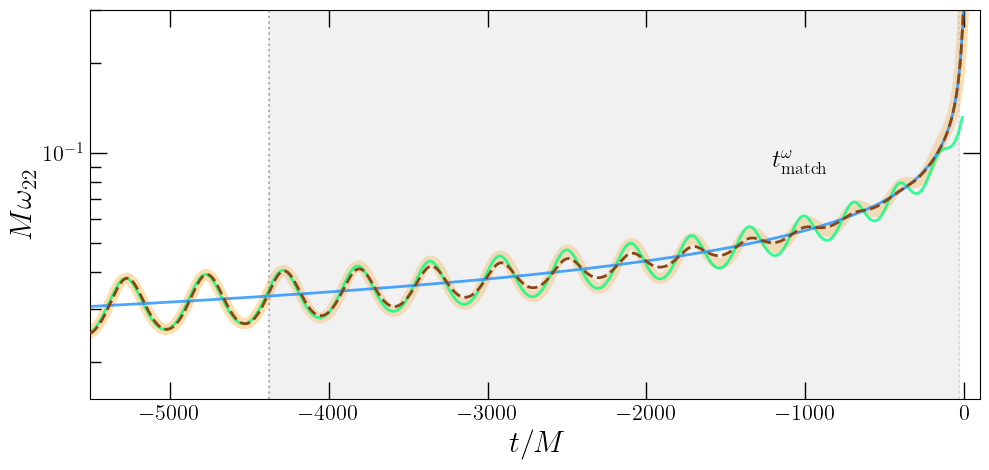

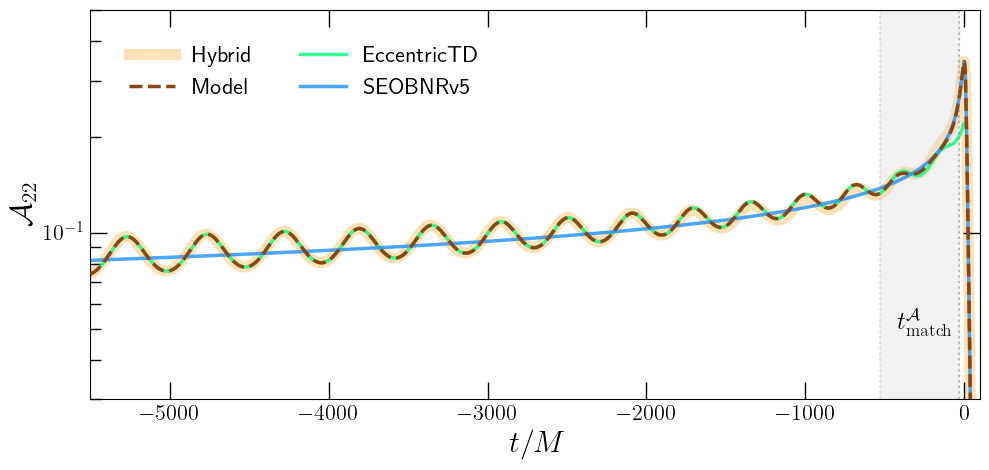

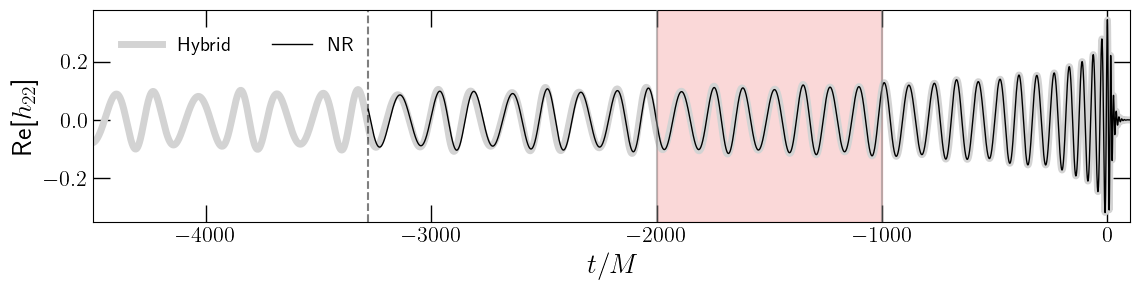

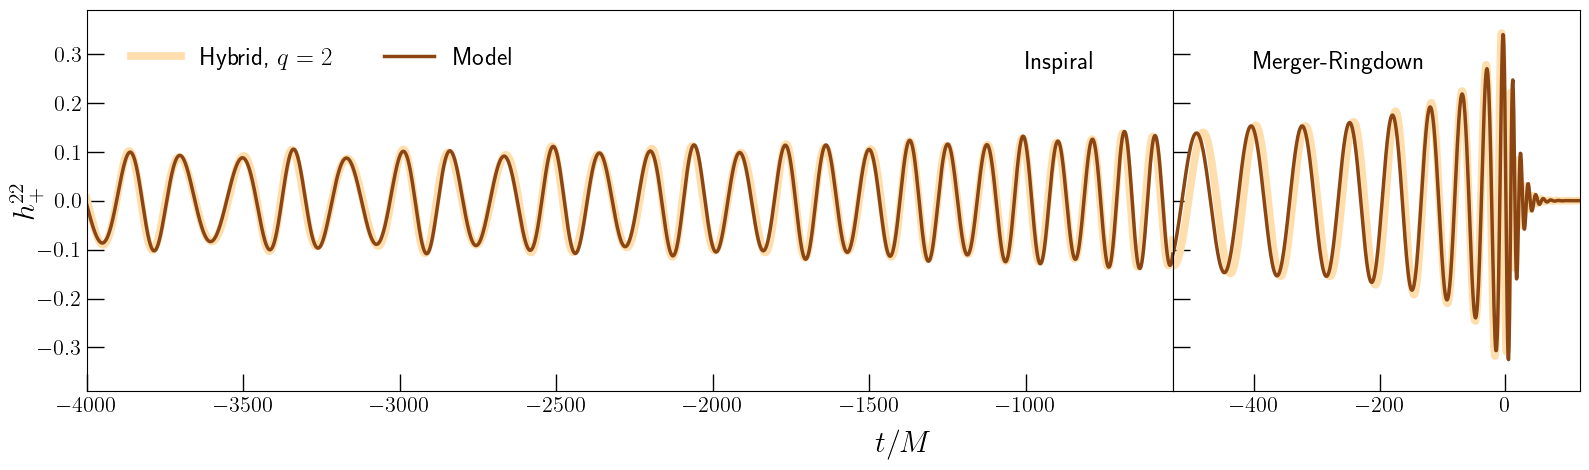

In [11]:
# model_22(30,1, 0.173,1.423,16.53,0,1,1/4096)
model_22(30,2, 0.172,-0.181,16.68,0,1,1/4096)
# model_22(30,3, 0.3,3.005,13.75,0,1,1/4096)

In [28]:
# ?plt.text

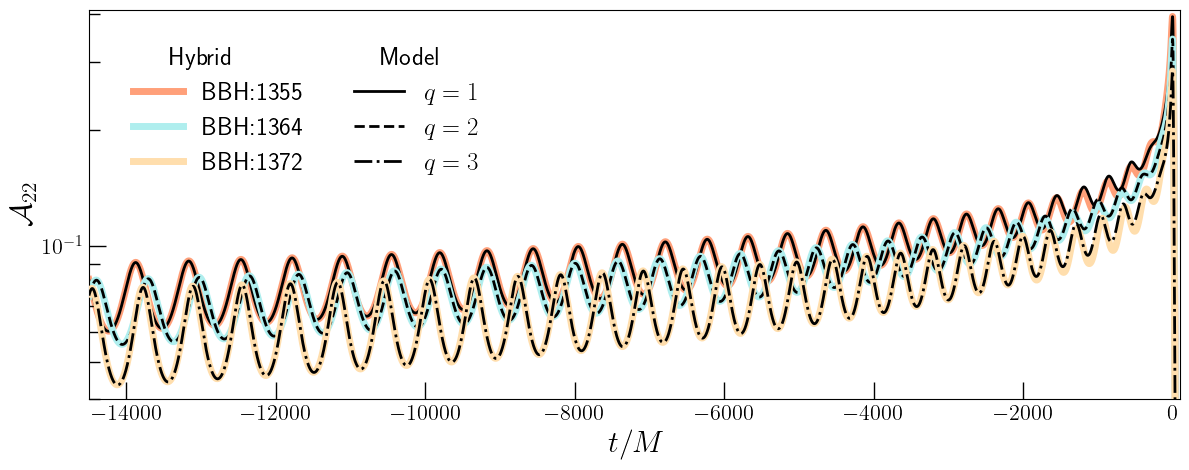

In [31]:
#plt.figure(figsize=(15,6))
plt.figure(figsize=(12,4.8))
#plt.plot([],[],color='white',label=r'Hybrid Model')
plt.plot(tNR1355,NR1355,color='lightsalmon',linewidth=5.0,label=r'BBH:1355',zorder=0)
plt.plot(tNR1364,NR1364,color='paleturquoise',linewidth=5.0,label=r'BBH:1364 ',zorder=2)
plt.plot(tNR1372,NR1372,color='navajowhite',linewidth=5.0,label=r'BBH:1372',zorder=4)


#plt.plot([],[],color='white',label=' ')
plt.plot(tm1355,m1355,color='k',linewidth=2,linestyle='-',label = r'$q=1$',zorder=1)
plt.plot(tm1364,m1364,color='k',linewidth=2,linestyle='--',label = r'$q=2$',zorder=3)
plt.plot(tm1372,m1372,color='k',linewidth=2,linestyle='-.',label = r'$q=3$',zorder=5)

plt.plot()
plt.ylim(ymax=4.1e-1)
plt.ylim(ymin=4e-2)
plt.yscale('log')
plt.xlim(xmin=-14500)
plt.xlim(xmax=100)
#plt.title("PN-NR",fontsize=18)
plt.ylabel(r"$\mathcal{A}_{22}$", fontsize=22)
plt.xlabel(r"$t/M$", fontsize=22)
#plt.legend(ncol=2,title = r"Hybrid  Model",title_fontsize=15)

leg = plt.legend(frameon=False,ncol=2,loc=2,bbox_to_anchor=(0.02,0.96),title = r"Hybrid $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Model",title_fontsize=18,prop={'size': 18})
leg._legend_box.align = "center"
plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.tight_layout()
#plt.savefig('amp_model.pdf')
plt.savefig('/home/pratul/Downloads/Project/Plots_draft/amp_model_diff_sims.pdf',dpi=300)

In [ ]:
?plt.legend

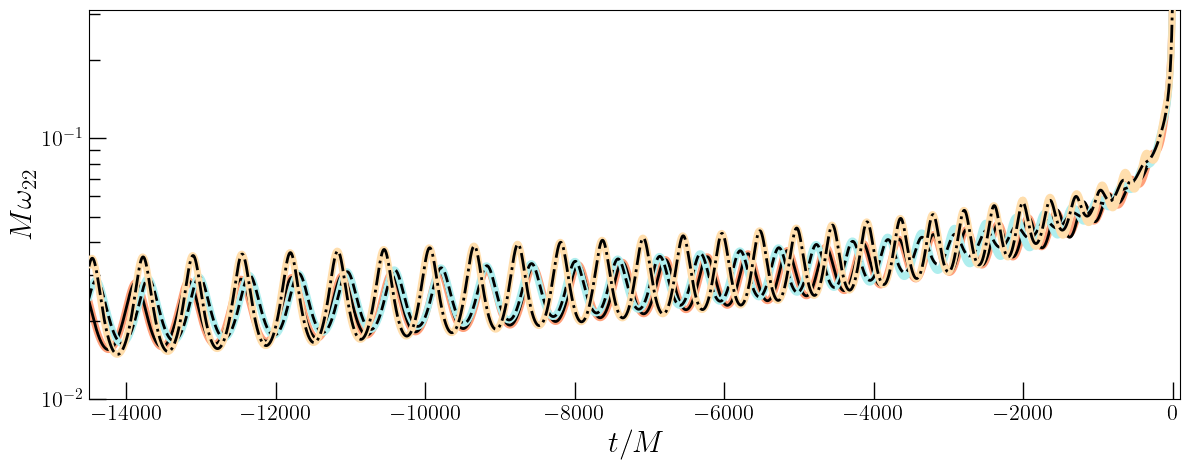

In [32]:
#plt.figure(figsize=(15,6))
plt.figure(figsize=(12,4.8))
#plt.plot([],[],color='white',label=r'Hybrid Model')
plt.plot(tNR1355,omega1355,color='lightsalmon',linewidth=5.0,label=r'BBH:1355',zorder=0)
plt.plot(tNR1364,omega1364,color='paleturquoise',linewidth=5.0,label=r'BBH:1364 ',zorder=2)
plt.plot(tNR1372,omega1372,color='navajowhite',linewidth=5.0,label=r'BBH:1372',zorder=4)


#plt.plot([],[],color='white',label=' ')
plt.plot(tm1355,momega1355,color='k',linewidth=2,linestyle='-',label = r'$q=1$',zorder=1)
plt.plot(tm1364,momega1364,color='k',linewidth=2,linestyle='--',label = r'$q=2$',zorder=3)
plt.plot(tm1372,momega1372,color='k',linewidth=2,linestyle='-.',label = r'$q=3$',zorder=5)

plt.plot()
plt.ylim(ymax=3.1e-1)
plt.ylim(ymin=1e-2)
plt.yscale('log')
plt.xlim(xmin=-14500)
plt.xlim(xmax=100)
#plt.title("PN-NR",fontsize=18)
plt.ylabel(r"$M \omega_{22}$", fontsize=22)
plt.xlabel(r"$t/M$", fontsize=22)
#plt.legend(ncol=2,title = r"Hybrid  Model",title_fontsize=15)

#leg = plt.legend(frameon=False,ncol=2,loc=2,bbox_to_anchor=(0.02,0.96),title = r"Hybrid $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Model",title_fontsize=18,prop={'size': 18})
#leg._legend_box.align = "center"
plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.tight_layout()
#plt.savefig('amp_model.pdf')
plt.savefig('/home/pratul/Downloads/Project/Plots_draft/freq_model_diff_sims.pdf',dpi=300)